In [8]:
import os
import pandas as pd


In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from kan.custom_processing import remove_outliers_iqr
import torch
import matplotlib.pyplot as plt
import numpy as np

datadir = os.path.join(os.getcwd(), 'data', 'co2_hydrogenation', 'data_parsed.csv')

with open(datadir, 'rb') as f:
        d_all = pd.read_csv(f)
d_all.iloc[:5]

,k,stage,i,step,flag,x,minimum_selling_price,CO2_emission,x1,x2,...,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16
0,0,line_search,0,0,success,[ 75. 75. 210. 210. 5. 1.6...,0.559402,-0.005662,75.00,75.0,...,0.6,35.0,1.0,1.3,83.0,208.0,280.0,1.2,1.0,0.485
1,0,line_search,0,1,success,[ 68.75 75. 210. 210. 5. 1.6...,0.558912,-0.004907,68.75,75.0,...,0.6,35.0,1.0,1.3,83.0,208.0,280.0,1.2,1.0,0.485
2,0,line_search,0,2,success,[ 62.5 75. 210. 210. 5. 1.6...,0.557627,-0.003348,62.50,75.0,...,0.6,35.0,1.0,1.3,83.0,208.0,280.0,1.2,1.0,0.485
3,0,line_search,0,3,success,[ 56.25 75. 210. 210. 5. 1.6...,0.555927,-0.001191,56.25,75.0,...,0.6,35.0,1.0,1.3,83.0,208.0,280.0,1.2,1.0,0.485
4,0,line_search,0,4,not_converged,[ 50. 75. 210. 210. 5. 1.6...,NaN,NaN,50.00,75.0,...,0.6,35.0,1.0,1.3,83.0,208.0,280.0,1.2,1.0,0.485


In [42]:
type_flags = d_all['flag'].unique()
print("Flag types:")
print(type_flags)

filedata = d_all[d_all['flag'] == 'success'].copy()
print(filedata['flag'].unique())
unsuccessful_count = len(d_all) - len(filedata)
print(f"# of unsuccessful data: {unsuccessful_count} / {len(d_all)} ({unsuccessful_count / len(d_all) * 100:.1f}%)")

Flag types:
['success' 'not_converged' 'product_spec_not_met']
['success']
# of unsuccessful data: 532 / 7490 (7.1%)


TARGET: CO2_emission
# of data after removing outliers: 1991 개 (4967 개 제거됨)
Train set: 1273 (63.9%)
Validation set: 319 (16.0%)
Test set: 399 (20.0%)


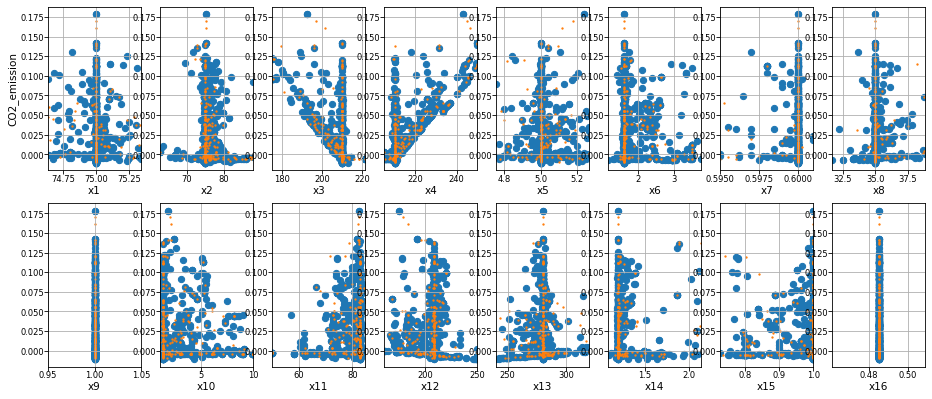

In [39]:
name_X = filedata.columns[-16:].tolist()
name_y = 'CO2_emission'
# name_y = 'minimum_selling_price'
df_in = filedata[name_X]
df_out = filedata[[name_y]]
print(f"TARGET: {name_y}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_in_final, df_out_final = df_in, df_out

df_in_final, df_out_final = remove_outliers_iqr(df_in, df_out, rr=20)
removed_count = len(df_in) - len(df_in_final)
print(f"# of data after removing outliers: {len(df_in_final)} 개 ({removed_count} 개 제거됨)")

X = df_in_final[name_X].values
y = df_out_final[name_y].values.reshape(-1, 1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2,
                                                  random_state=42)
print(f"Train set: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validation set: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Test set: {len(X_test)} ({len(X_test) / len(X) * 100:.1f}%)")

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_norm = scaler_X.fit_transform(X_train)
y_train_norm = scaler_y.fit_transform(y_train)

X_val_norm = scaler_X.transform(X_val)
X_test_norm = scaler_X.transform(X_test)

y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

y = df_out_final[name_y].values.reshape(-1, 1)

num_input = X.shape[1]
fig, axs = plt.subplots(2, int(np.ceil(num_input/2)), figsize=(15, 6))
axs = np.atleast_1d(axs).flatten()

for i in range(num_input):
    ax = axs[i]
    ax.scatter(X_train[:, i], y_train)
    ax.scatter(X_test[:, i], y_test, s=1.5)
    ax.set_xlabel(name_X[i])
    ax.grid()
axs[0].set_ylabel(name_y)
plt.show()
